# <font color="blue">樹狀分類器</font>
<p align="left">
<table>
    <tr>
        <td style="text-align:left">
            <font size="3">樹狀分類器例如:</font>
            <ul>
            <li><font size="3" color="red">RandomForestClassifier</font> </li>   
            <li><font size="3" color="red">DecisionTreeClassifier</font> </li>            
            <li><font size="3" color="red">BoostedTreesClassifier</font> </li>              
            </ul>
            <font size="3">有許多特點</font>
            <ul>
            <li><font size="3">非常適合結構化資料的分類或迴歸問題。</font></li>
            <li><font size="3">通常也具備良好的解釋決策理由的能力。</font></li>
            <li><font size="3">理論上，樹狀分類器可以應付混合數值型屬性與類別型屬性的資料。</font></li>
                <ul><li><font size="3">但有時候為了更有效的資料表示或是單純只是遷就演算法，會將資料屬性轉換成另一種表示方式。</font></li></ul>
            </ul>
        </td>
        <td>
            <img src="attachment:decision_tree.png" width="250">
        </td>
     <tr>
</table>
</p>

### 解釋力
至少有三種方式可用來解釋每個屬性對樹狀分類器建構的重要性，其中DFC也可以描述每個屬性對某一個樣本在樹狀分類器決策的貢獻。
+ **Gain-based feature importance**:樹狀分類器建構過程中，整體樣本類別(或迴歸值)不確定性，會隨著訓練樣本在樹結構裡分流(類似的訓練樣本會同流)跟著降低。某個屬性在樹狀分類器建構過程中降低不明確性的總量，可以視為此屬性的重要性。 
+ **Directional feature contribution (DFC)**:以迴歸問題為例。若樹狀迴歸函數對樣本$x$的輸出值為$y$時，可視為從落在樹根部節點內訓練樣本的平均迴歸值($y_{root}$)到落在決策的葉節點內訓練樣本的平均迴歸值(y)的調整過程
\begin{equation}
y = y_{root} + \sum_{i=1}^{d}contrib(a_{i})
\end{equation}
屬性$a_{i}$對樣本$x$的決策的重要性可以與$contrib(a_{i})$的絕對值成正比。
<div>
    <img src="attachment:dfc.png" width="300">
</div>
由上圖知道這個決策路徑對應的迴歸值可以看成這樣計算$y=83=40 + 30 + 20 -10 + 3$，因此屬性$a_{1},a_{2},a_{3},a_{4}$對應DFC為$30,20,-10,3$。
+ **Permutation feature importance**:某個屬性參予和不參予樹狀分類器建構，所造成的準確度差異，就是此屬性的重要性。 


實驗首先，先準備好Kaggle帳號以利收集訓練資料資料集
註冊Kaggle帳號後，可依以下步驟，讓Google CoLab可以使用kaggle資料:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

1) ! pip install -q kaggle

2) from google.colab import files

files.upload()

Choose the kaggle.json file that you downloaded

3) ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

Make directory named kaggle and copy kaggle.json file there.
4) ! chmod 600 ~/.kaggle/kaggle.json

Change the permissions of the file.
5) ! kaggle datasets list
- That's all ! You can check if everything's okay by running this command.

Download Data
! kaggle competitions download -c 'name-of-competition'

Use unzip command to unzip the data:

For example,

Create a directory named train,

! mkdir train

unzip train data there,

! unzip train.zip -d train

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sklearn as sk
import os
from IPython.display import clear_output, display
%matplotlib inline

tf.get_logger().setLevel('ERROR')    

try:
    from treeinterpreter import treeinterpreter as ti
except:
    !pip install treeinterpreter
    from treeinterpreter import treeinterpreter as ti
    
try:
    import kaggle
except:    
    from google.colab import files
    files.upload() #this will prompt you to update the json

    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json  # set permission
    

Saving kaggle.json to kaggle (1).json
kaggle.json


## 下載資料集
heart-disease-uci這個資料集在<a href="https://www.kaggle.com/" target="_blank" title="kaggle">kaggle</a>或<a href="https://archive.ics.uci.edu/ml/datasets.php" target="_blank" title="UCI ML Respository">UCI Machine Learning Respository</a>都可以下載。
<a href="https://github.com/Kaggle/kaggle-api" target="_blank" title="kaggle API">kaggle API說明</a>

In [4]:
# 看看在kaggle上有幾個UCI datasets
!kaggle datasets list -s UCI

ref                                                   title                                            size  lastUpdated          downloadCount  
----------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                              Heart Disease UCI                                 3KB  2018-06-25 11:33:56         193477  
jessicali9530/kuc-hackathon-winter-2018               UCI ML Drug Review dataset                       41MB  2018-11-12 19:44:19           7140  
mashlyn/online-retail-ii-uci                          Online Retail II UCI                             15MB  2019-12-02 11:03:36           2165  
paresh2047/uci-semcom                                 UCI SECOM Dataset                                 2MB  2018-05-28 15:04:08           2453  
loganalive/echocardiogram-uci                         echocardiogram-UCI                                2KB  2018-04-25 15:3

### 由kaggle下載 heart-disease-uci
要在環境做一點準備才可以用下面指令(<a href="https://github.com/Kaggle/kaggle-api" target="_blank" title="kaggle API">kaggle API說明</a>)，不然手動下載heart-disease-uci.zip。

In [5]:
if not os.path.exists('heart-disease-uci.zip'):
    !kaggle datasets download ronitf/heart-disease-uci

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 488kB/s]


In [6]:
# read heart-disease-uci.zip
df = pd.read_csv('heart-disease-uci.zip',compression='zip')

### 屬性資訊:
1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral (血清膽固醇) in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina (心絞痛)
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target 1 (positive); 0 (negative) (將來要根據樣本的屬性1~13來預測此樣本的target)

In [7]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


這個資料集13個屬性可分為兩種型態:
+ 數值(numeric): age, trestbps, chol, thalach, oldpeak, slope, ca
+ 類別(categorical): cp, restecg, thal, sex, fbs, exang

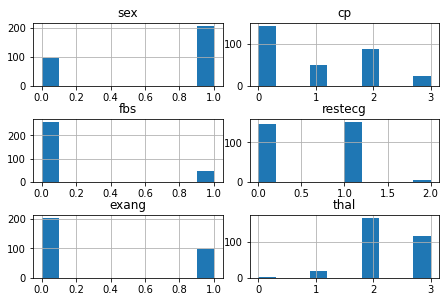

In [8]:
df[['sex','cp','fbs','restecg','exang','thal']].hist();
plt.tight_layout(False)

## 分拆訓練集合、驗證集合、測試集合
注意，由於此資料集樣本數不多，不適合只用一次分拆的測試集合來評斷不同分類器的準確度。

In [9]:
from sklearn.model_selection import train_test_split
train, test  = train_test_split(df,test_size=0.2)
train, valid = train_test_split(train,test_size=0.1)

train_x = train.copy()
train_y = train_x.pop('target')
valid_x = valid.copy()
valid_y = valid_x.pop('target')
test_x  = test.copy()
test_y  = test_x.pop('target')

pd.concat([train_x,train_y],axis=1).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
184,50,1,0,150,243,0,0,128,0,2.6,1,0,3,0
11,48,0,2,130,275,0,1,139,0,0.2,2,0,2,1
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1
73,51,1,0,140,261,0,0,186,1,0.0,2,0,2,1
250,51,1,0,140,298,0,1,122,1,4.2,1,3,3,0


In [10]:
df.iloc[[80,59,186],:].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2,1
59,57,0,0,128,303,0,0,159,0,0.0,2,1,2,1
186,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0


## 分析屬性類別與特徵工程
Tensorflow 提供下面屬性類別可供轉換:
+ numeric column
+ bucketized column
+ categorical column
+ embedding column
+ hashed feature column
+ crossed feature column

### 轉換資料屬性以適合分類器訓練

In [11]:
from tensorflow import feature_column 
from tensorflow.keras import layers
fc = tf.feature_column
NUMERIC_COLUMNS     = ['age','trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']
BUCKETIZED_COLUMNS  = [(feature_column.numeric_column('age',dtype=tf.float32),list(np.linspace(15,65,11)))]
CATEGORICAL_COLUMNS = ['sex','cp','fbs','restecg','exang']

#embedding_column在BoostedTreesClassifier怪怪的
EMBEDDING_COLUMNS   = []#[(feature_column.categorical_column_with_identity('thal',100000),8)]

HASHED_COLUMNS      = [('thal',100)]
CROSSED_COLUMNS     = [(feature_column.bucketized_column(feature_column.numeric_column('age',dtype=tf.float32),list(np.linspace(15,65,11))),
                        feature_column.categorical_column_with_vocabulary_list('thal',train_x['thal'].unique(),dtype=tf.int32),100)]

In [12]:
feature_columns = []

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(feature_column.numeric_column(feature_name,dtype=tf.float32))

for (nc,boundaries) in BUCKETIZED_COLUMNS:
    feature_columns.append(feature_column.bucketized_column(nc,boundaries=boundaries))
    
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_x[feature_name].unique()
    one_hot    = feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary)
    feature_columns.append(feature_column.indicator_column(one_hot))

for (c_fc,dim) in EMBEDDING_COLUMNS:
    ec = feature_column.embedding_column(c_fc,dimension=dim)
    feature_columns.append(ec)
    
for (feature_name,hash_bucket_size) in HASHED_COLUMNS:
    hashed_bucket = feature_column.categorical_column_with_hash_bucket(feature_name,hash_bucket_size=hash_bucket_size,dtype=tf.int32)
    feature_columns.append(feature_column.indicator_column(hashed_bucket))
    
for (f1,f2,hash_bucket_size) in CROSSED_COLUMNS:
    crossed_feature = feature_column.crossed_column([f1,f2],hash_bucket_size=hash_bucket_size)
    feature_columns.append(feature_column.indicator_column(crossed_feature))

### 使用tf.data建立資料輸入管道

In [13]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(len(y))
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(len(y))
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(train_x, train_y)
valid_input_fn = make_input_fn(valid_x, valid_y)
test_input_fn  = make_input_fn(test_x, test_y,1)    

### 使用人工類神經網路

In [16]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_input_fn(),epochs=30,validation_data=valid_input_fn(),steps_per_epoch=10,validation_steps=10,verbose=0)
results = model.evaluate(test_input_fn(),verbose=0)
pd.Series({'loss':results[0],'acc':results[1]}).to_frame()

,0
loss,0.375198
acc,0.836066


## 使用tensorflow裡的BoostedTreesClassifier

In [17]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns,**params)

est.train(train_input_fn, max_steps=100)

In [18]:
# Eval.
results = est.evaluate(test_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803279
accuracy_baseline,0.622951
auc,0.915332
auc_precision_recall,0.941363
average_loss,0.360661
label/mean,0.622951
loss,0.360661
precision,0.861111
prediction/mean,0.556877
recall,0.815789


### 檢視資料屬性重要性
est.experimental_feature_importances()會得到每個屬性gain-based重要性。

In [21]:
pd.DataFrame({name:[v] for name,v in est.experimental_feature_importances().items()}).T

,0
thal,0.616019
cp,0.395152
oldpeak,0.353645
ca,0.350848
thalach,0.289265
slope,0.240333
chol,0.197059
age,0.177571
trestbps,0.171806
sex,0.119014


### 檢視訓練樣本整體DFC

In [22]:
pred_dicts = list(est.experimental_predict_with_explanations(make_input_fn(train_x, train_y,1)))
# Create DFC Pandas dataframe.
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.abs().describe().T.sort_values(['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
thal,217.0,0.076227,0.028475,0.002122,0.054242,0.069936,0.095353,0.156751
ca,217.0,0.068198,0.037616,0.004345,0.044541,0.067458,0.086656,0.181707
cp,217.0,0.066000,0.025996,0.001097,0.047962,0.059645,0.086807,0.146658
oldpeak,217.0,0.065423,0.045642,0.000071,0.030482,0.049658,0.096977,0.192623
thalach,217.0,0.050890,0.044309,0.000197,0.010590,0.034551,0.088473,0.191989
slope,217.0,0.039058,0.018523,0.000050,0.027169,0.033081,0.052263,0.118344
restecg,217.0,0.027278,0.032213,0.000000,0.002448,0.015535,0.037448,0.142122
trestbps,217.0,0.027243,0.029590,0.000464,0.010525,0.019901,0.033918,0.200431
chol,217.0,0.026689,0.027602,0.000119,0.007543,0.016759,0.036405,0.155919
age,217.0,0.025734,0.026786,0.000061,0.008321,0.020712,0.031176,0.197812


### 檢視測試樣本整體DFC

In [24]:
pred_dicts = list(est.experimental_predict_with_explanations(test_input_fn))
# Create DFC Pandas dataframe.
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.abs().describe().T.sort_values(['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
thal,61.0,0.071020,0.023544,0.023419,0.054901,0.070201,0.078711,0.146161
ca,61.0,0.066241,0.030884,0.016410,0.044504,0.054815,0.087000,0.143917
cp,61.0,0.062159,0.027552,0.001501,0.047116,0.060318,0.085104,0.106908
oldpeak,61.0,0.061306,0.042964,0.006491,0.028536,0.045284,0.102561,0.173740
thalach,61.0,0.057239,0.044840,0.001015,0.013724,0.055682,0.091111,0.156558
slope,61.0,0.039251,0.016983,0.016393,0.022459,0.038421,0.052890,0.069760
restecg,61.0,0.029456,0.033924,0.000000,0.004574,0.017326,0.043894,0.173318
chol,61.0,0.028610,0.029132,0.000294,0.007030,0.022706,0.036092,0.132638
sex,61.0,0.026082,0.029092,0.001414,0.007424,0.017415,0.031010,0.167240
age_bucketized_X_thal,61.0,0.025968,0.018000,0.000704,0.011651,0.023673,0.035853,0.074933


### 檢視特定樣本DFC

In [25]:
pd.DataFrame([pred_dicts[2]['dfc']]).abs().head(1).T

,0
thalach,0.121972
cp,0.057288
thal,0.056539
ca,0.054815
slope,0.053771
oldpeak,0.028336
trestbps,0.022067
restecg,0.021205
sex,0.020644
age,0.019714


## 使用sklearn裡的RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=96)
rf_clf.fit(train_x, train_y)
rf_acc = rf_clf.score(test_x,test_y)
print('random forest accuracy: {:.3f}'.format(rf_acc))

random forest accuracy: 0.852


### 檢視資料屬性重要性
rf_clf.importances_紀錄每一個資料屬性，在建立RandomForest時對降低整體資料不確定性的貢獻，值越高者貢獻越大。

In [ ]:
pd.DataFrame({name:[cr] for cr,name  in zip(rf_clf.feature_importances_,train_x.columns)}).head().T.sort_values([0],ascending=False)    

,0
cp,0.132969
thalach,0.131667
thal,0.128249
oldpeak,0.112895
ca,0.092534
age,0.091814
chol,0.072204
trestbps,0.065925
exang,0.064876
sex,0.036299


### 檢視訓練樣本整體DFC

In [ ]:
prediction, bias, contributions = ti.predict(rf_clf, train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.114819
thal,0.109304
ca,0.080728
oldpeak,0.066684
thalach,0.064150
exang,0.064032
age,0.044197
sex,0.040210
slope,0.030140
chol,0.028573


### 檢視測試樣本整體DFC

In [ ]:
prediction, bias, contributions = ti.predict(rf_clf, test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
thal,0.123828
cp,0.119058
ca,0.073853
exang,0.071482
oldpeak,0.068716
thalach,0.058116
sex,0.036279
age,0.033680
slope,0.028190
trestbps,0.025638


### 檢視特定樣本DFC

In [ ]:
instance_id = 10
prediction, bias, contributions = ti.predict(rf_clf, test_x[instance_id:instance_id+1])
class_id = np.argmax(prediction[0,:])
pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.abs(np.array(contributions[0,:,class_id])).ravel())}).head().T.sort_values([0],ascending=False)

,0
cp,0.094900
thal,0.078247
age,0.058272
thalach,0.051212
ca,0.049782
oldpeak,0.043714
sex,0.035215
exang,0.030270
slope,0.019634
chol,0.014074


## 使用sklearn裡的DecisionTreeClassifier

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt_clf = DecisionTreeClassifier(random_state=96)
dt_clf.fit(train_x,train_y)
dt_acc = dt_clf.score(test_x,test_y)
print('decision tree accuracy: {:.3f}'.format(dt_acc))

decision tree accuracy: 0.721


### 檢視資料屬性重要性
dt_clf.importances_紀錄每一個資料屬性，在建立RandomForest時對降低整體資料不確定性的貢獻，值越高者貢獻越大。

In [28]:
pd.DataFrame({name:[cr] for cr,name  in zip(dt_clf.feature_importances_,train_x.columns)}).head().T.sort_values([0],ascending=False)    

,0
thal,0.277494
age,0.138629
oldpeak,0.100010
ca,0.097979
trestbps,0.094579
slope,0.092465
cp,0.070773
chol,0.065598
thalach,0.035391
sex,0.012310


### 顯示決策樹結構

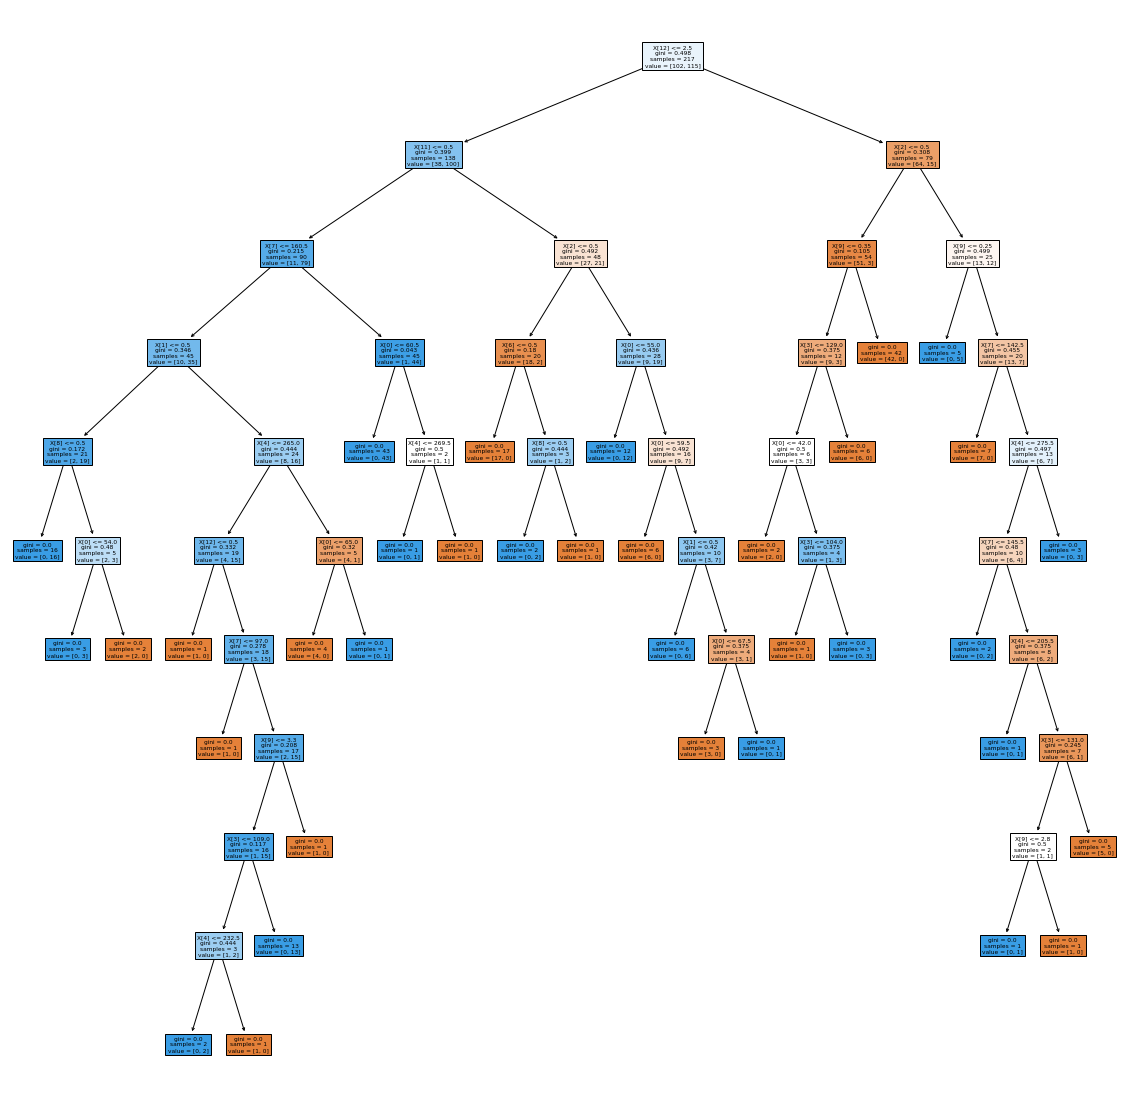

In [ ]:
plt.figure(figsize=(20,20))
a=plot_tree(dt_clf, filled=True) 
plt.savefig('decision_tree.pdf')

### 檢視訓練樣本整體DFC

In [ ]:
prediction, bias, contributions = ti.predict(dt_clf, train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
thal,0.253098
cp,0.129061
ca,0.127029
age,0.080301
thalach,0.064055
oldpeak,0.057011
chol,0.049524
sex,0.041167
trestbps,0.032505
exang,0.020189


### 檢視測試樣本整體DFC

In [ ]:
prediction, bias, contributions = ti.predict(dt_clf, test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
thal,0.272169
cp,0.132898
oldpeak,0.101752
ca,0.090692
trestbps,0.067769
age,0.052147
chol,0.048275
thalach,0.038731
sex,0.031434
exang,0.030601


### 檢視特定樣本DFC

In [ ]:
instance_id = 10
prediction, bias, contributions = ti.predict(dt_clf, test_x[instance_id:instance_id+1])
class_id = np.argmax(prediction[0,:])
pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.abs(np.array(contributions[0,:,class_id])).ravel())}).head().T.sort_values([0],ascending=False)

,0
thal,0.194684
ca,0.153140
thalach,0.100000
age,0.022222
sex,0.000000
cp,0.000000
trestbps,0.000000
chol,0.000000
fbs,0.000000
restecg,0.000000


In [ ]:
#
def extract_rules(clf,names=None):
    def dfs(node_id,precond):
        if clf.tree_.children_left[node_id]==-1 and clf.tree_.children_right[node_id]==-1: # a leaf node
            val = clf.tree_.value[node_id].ravel()
            pp  = val/np.sum(val)
            pp  = ','.join(['{:.3f}'.format(x) for x in pp])
            pr  = ' and '.join(precond)
            rules.append('if '+ pr +' then ' + 'class {}, '.format(np.argmax(val)) + 'posterior prob. ['+ pp +']')
            return
        if clf.tree_.children_left[node_id] >= 0:
            new_precond = precond.copy()
            new_precond.append('{}<={:.3f}'.format(names[clf.tree_.feature[node_id]],clf.tree_.threshold[node_id])) 
            dfs(clf.tree_.children_left[node_id], new_precond)
        if clf.tree_.children_right[node_id] >= 0:
            new_precond = precond.copy()
            new_precond.append('{}>{:.3f}'.format(names[clf.tree_.feature[node_id]],clf.tree_.threshold[node_id])) 
            dfs(clf.tree_.children_right[node_id], new_precond)
        return
#-------------------------------------------------    
    if names is None:
        names = ['f_{}'.format(x) for x in range(clf.tree_.n_features)]
    
    rules = []
    precond=[]
    dfs(0,precond)
    return rules

In [ ]:
extract_rules(dt_clf,train_x.columns)

['if thal<=2.500 and ca<=0.500 and thalach<=160.500 and sex<=0.500 and exang<=0.500 then class 1, posterior prob. [0.000,1.000]',
 'if thal<=2.500 and ca<=0.500 and thalach<=160.500 and sex<=0.500 and exang>0.500 and age<=54.000 then class 1, posterior prob. [0.000,1.000]',
 'if thal<=2.500 and ca<=0.500 and thalach<=160.500 and sex<=0.500 and exang>0.500 and age>54.000 then class 0, posterior prob. [1.000,0.000]',
 'if thal<=2.500 and ca<=0.500 and thalach<=160.500 and sex>0.500 and chol<=265.000 and thal<=0.500 then class 0, posterior prob. [1.000,0.000]',
 'if thal<=2.500 and ca<=0.500 and thalach<=160.500 and sex>0.500 and chol<=265.000 and thal>0.500 and thalach<=97.000 then class 0, posterior prob. [1.000,0.000]',
 'if thal<=2.500 and ca<=0.500 and thalach<=160.500 and sex>0.500 and chol<=265.000 and thal>0.500 and thalach>97.000 and oldpeak<=3.300 and trestbps<=109.000 and chol<=232.500 then class 1, posterior prob. [0.000,1.000]',
 'if thal<=2.500 and ca<=0.500 and thalach<=160

## 使用tf.data與sklearn的RandomForestClassifier與DecisionTreeClassifier

In [ ]:
fc_train_x = feature_layer(dict(train_x)).numpy()
fc_test_x  = feature_layer(dict(test_x)).numpy()

In [ ]:
rf_clf.fit(fc_train_x,train_y)
rf_acc = rf_clf.score(fc_test_x,test_y)
print("RandomForest test accuracy:{:.3f}".format(rf_acc))

dt_clf.fit(fc_train_x,train_y)
dt_acc = dt_clf.score(fc_test_x,test_y)
print("DecisionTree test accuracy:{:.3f}".format(dt_acc))

RandomForest test accuracy:0.770
DecisionTree test accuracy:0.754


### 顯示Gain-based Importance

In [29]:
from tensorflow_estimator.python.estimator.canned import boosted_trees_utils
from tensorflow_estimator.python.estimator.canned.boosted_trees import _generate_feature_col_name_mapping
pd.DataFrame({name:[cr] for name,cr  in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), rf_clf.feature_importances_).items()}).head().T    

,0
age_bucketized_X_thal,0.887950
age,0.077762
age_bucketized,0.034288


In [30]:
pd.DataFrame({name:[cr] for name,cr  in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), dt_clf.feature_importances_).items()}).head().T    

,0
age_bucketized_X_thal,0.849061
age,0.138629
age_bucketized,0.012310


### 檢視測試樣本整體DFC

In [33]:
prediction, bias, contributions = ti.predict(rf_clf, fc_test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name,cr in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), np.mean(np.array(contrib),axis=0)).items()}).head().T    

NameError: ignored

In [32]:
prediction, bias, contributions = ti.predict(dt_clf, fc_test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name,cr in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), np.mean(np.array(contrib),axis=0)).items()}).head().T    

NameError: ignored